# Simple comparison between disort and hapke model results. 

## Setup and Imports

In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from copy import deepcopy

# Import thermal model components
from core.config_manager import ConfigManager, create_default_base_config
from core.thermal_simulation import ThermalSimulator
from modelmain import Simulator
from config import SimulationConfig
from modelmain import emissionT

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

print("Imports completed successfully!")

Imports completed successfully!


## Create and Load Base Simulation Configuration

Create and load in a default config file. 

In [2]:
# Option 1: Create a new default configuration
config_path = "../configs/base_configs/analysis_template.yaml"

# Create config directory if it doesn't exist
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Create default configuration for analysis
create_default_base_config(config_path)

# Load the configuration
config_manager = ConfigManager(config_path)

# Create base configuration
base_config = config_manager.create_config()

print(f"Configuration created at: {config_path}")
print(f"Loaded configuration.")


Default configuration saved to: ../configs/base_configs/analysis_template.yaml
Configuration created at: ../configs/base_configs/analysis_template.yaml
Loaded configuration.


## Run the two thermal models



In [35]:
# Modify base configuration for our analysis
settings = {
    'diurnal': True,                       # Steady state simulation
    'use_RTE': True,                      # Use radiative transfer equation solver
    'ndays': 10,                          # Number of days for convergence
    'freq_out': 48,                       # Output frequency (hourly)
    'last_day': True,                     # Only output final day
    'sun': True,                           # Include solar heating
    'T_fixed': False,                        # Temperature is fixed, prevents thermal evolution
    'compute_observer_radiance': False,      # Compute radiance outputs. 
    'thermal_evolution_mode': 'two_wave',   #Run thermal evolution later with broadband vis (turned off) and broadband thermal. 
    'output_radiance_mode': 'two_wave',       #Compute spectral radiance in thermal only. 
    'observer_mu': 1.0,                     # Observer zenith angle (0 for nadir)
    'g_therm': 0.0,                         # Asymmetry parameter for thermal radiation (average from mie code)
    'g_vis': 0.0,                           # Asymmetry parameter for visible radiation (average from mie code)
    'R_base': 0.0,                          # Global reflectivity value for substrate     
    'disort_space_temp': 0.,              # Cold shroud temperature
    'k_dust': 5.5e-4,                       # Phonon thermal conductivity of dust (W/m/K)
    'rho_dust': 1100.0,                    # Density of dust (kg/m³)
    'cp_dust': 825.0,                      # Specific heat capacity of dust (J/kg/K)
    'latitude': np.radians(0.0),           # Latitude in radians (0 for equator)
    'dec': np.radians(0.0),                # Declination in radians (0 for no seasonal effects)
    'R': 1.0,                          # Distance from the Sun in AU
    'P': 15450.0,
    'single_layer': True,                   # Use single-layer model
    'dust_thickness': 1.0,                # 3 mm thick sample
    'T_bottom': 300.0,                        # Sample base fixed at 500 K
    'bottom_bc': 'neumann',               # Bottom boundary condition (fixed temperature)
    'ssalb_vis': 0.8,                      # Single scattering albedo for visible radiation
    'ssalb_therm': 0.0,                     # Single scattering albedo for thermal radiation
    'Et': 500.0,
    'dtfac': 10.0,                     # Time step factor for adaptive time-stepping
    'minsteps': 10000,                   # Minimum number of time steps
    'nmom': 2,                            # Number of moments for DISORT
    'nstr': 2,                          # Number of streams for DISORT
    'dust_rte_max_lthick': 0.025,      # First layer thickness in tau units. 
}



# Create configuration with overrides
settings['RTE_solver'] = 'disort'  # Use DISORT solver
config_disort = config_manager.create_config(settings)
config_disort.__post_init__()

settings['RTE_solver'] = 'hapke'  # Use
config_hapke = config_manager.create_config(settings)
config_hapke.__post_init__()

print("Running baseline simulation...")


# Run simulation
sim_hapke = Simulator(config_hapke)
T_out_hapke, phi_vis_hapke, phi_therm_hapke, T_surf_hapke, t_out_hapke = sim_hapke.run(calculate_radiance=False)
sim_disort = Simulator(config_disort)
T_out_ds, phi_vis_ds, phi_therm_ds, T_surf_ds, t_out_ds = sim_disort.run(calculate_radiance=False)
print("Simulation completed.")

Running baseline simulation...
Time step: 1.545000 s, Steps per day: 10000
Time step 0/100000
Time step 5000/100000
Time step 10000/100000
Time step 15000/100000
Time step 20000/100000
Time step 25000/100000
Time step 30000/100000
Time step 35000/100000
Time step 40000/100000
Time step 45000/100000
Time step 50000/100000
Time step 55000/100000
Time step 60000/100000
Time step 65000/100000
Time step 70000/100000
Time step 75000/100000
Time step 80000/100000
Time step 85000/100000
Time step 90000/100000
Time step 95000/100000
Simulation completed in 5.55 s
Time step: 1.545000 s, Steps per day: 10000
Thermal evolution mode: two_wave
Time step 0/100000
Time step 5000/100000
Time step 10000/100000
Time step 15000/100000
Time step 20000/100000
Time step 25000/100000
Time step 30000/100000
Time step 35000/100000
Time step 40000/100000
Time step 45000/100000
Time step 50000/100000
Time step 55000/100000
Time step 60000/100000
Time step 65000/100000
Time step 70000/100000
Time step 75000/100000

## Plot isothermal spectrum

No temperature gradient, approximate for an ambient lab measurement. 

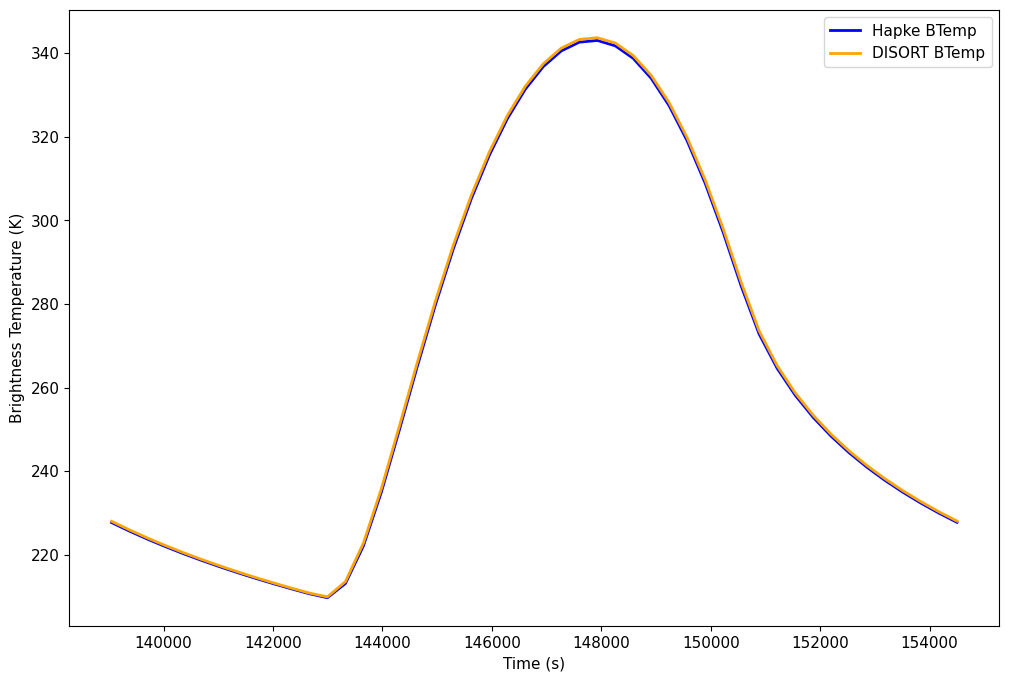

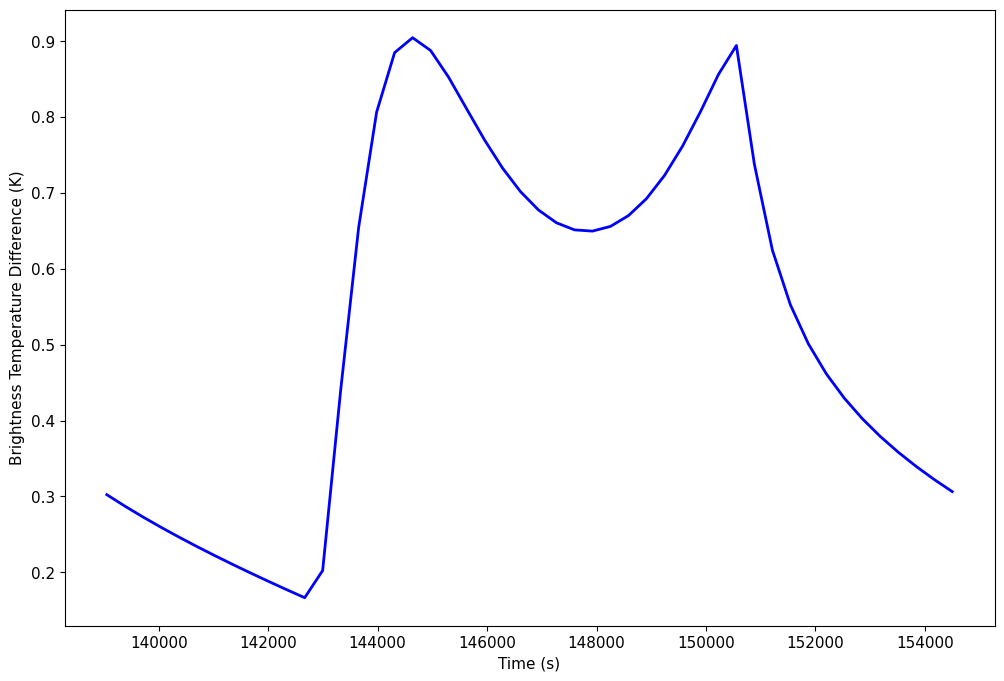

In [36]:
mu = 1.0
hapke_btemp = emissionT(T_out_hapke[1:-1,:], sim_hapke.grid.x_boundaries,0.0,mu)
ds_btemp = emissionT(T_out_ds[1:-1,:], sim_disort.grid.x_boundaries,0.0,mu)
plt.plot(t_out_hapke, hapke_btemp, label='Hapke BTemp', color='blue')
plt.plot(t_out_ds, ds_btemp, label='DISORT BTemp', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Brightness Temperature (K)')
plt.legend()
plt.show()

plt.plot(t_out_hapke, ds_btemp - hapke_btemp, label='Difference', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Brightness Temperature Difference (K)')
plt.show()